## ELETTRA-09: Local ID correction (ORM)

In [1]:
# In this example effects of an ID (APPLE-II device represented by a linear 4x4 symplectic matrix) are presented

# Local knobs are used to correct for ID effects (model free) by observing ORM

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.corrector import Corrector
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.orbit import ORM
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

from model.command.wrapper import Wrapper
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Define list of element names with trim coils
# Note, individual correctors are added separatly

names = ['SD_S01_01', 'SD_S01_02', 'SD_S01_03', 'SD_S01_04', 'SD_S01_07', 'SD_S01_08', 'SD_S01_09', 'SD_S01_10', 'SF_S01_01', 'SF_S01_06', 'SH_S01_01', 'SH_S01_04', 'OCT_S01_01', 'OCT_S01_04', 'SD_S02_01', 'SD_S02_02', 'SD_S02_03', 'SD_S02_04', 'SD_S02_07', 'SD_S02_08', 'SD_S02_09', 'SD_S02_10', 'SF_S02_01', 'SF_S02_06', 'SH_S02_01', 'SH_S02_04', 'OCT_S02_01', 'OCT_S02_04', 'SD_S03_01', 'SD_S03_02', 'SD_S03_03', 'SD_S03_04', 'SD_S03_07', 'SD_S03_08', 'SD_S03_09', 'SD_S03_10', 'SF_S03_01', 'SF_S03_06', 'SH_S03_01', 'SH_S03_04', 'OCT_S03_01', 'OCT_S03_04', 'SD_S04_01', 'SD_S04_02', 'SD_S04_03', 'SD_S04_04', 'SD_S04_07', 'SD_S04_08', 'SD_S04_09', 'SD_S04_10', 'SF_S04_01', 'SF_S04_06', 'SH_S04_01', 'SH_S04_04', 'OCT_S04_01', 'OCT_S04_04', 'SD_S05_01', 'SD_S05_02', 'SD_S05_03', 'SD_S05_04', 'SD_S05_07', 'SD_S05_08', 'SD_S05_09', 'SD_S05_10', 'SF_S05_01', 'SF_S05_06', 'SH_S05_01', 'SH_S05_04', 'OCT_S05_01', 'OCT_S05_04', 'SD_S06_01', 'SD_S06_02', 'SD_S06_03', 'SD_S06_04', 'SD_S06_07', 'SD_S06_08', 'SD_S06_09', 'SD_S06_10', 'SF_S06_01', 'SF_S06_06', 'SH_S06_01', 'SH_S06_04', 'OCT_S06_01', 'OCT_S06_04', 'SD_S07_01', 'SD_S07_02', 'SD_S07_03', 'SD_S07_04', 'SD_S07_07', 'SD_S07_08', 'SD_S07_09', 'SD_S07_10', 'SF_S07_01', 'SF_S07_06', 'SH_S07_01', 'SH_S07_04', 'OCT_S07_01', 'OCT_S07_04', 'SD_S08_01', 'SD_S08_02', 'SD_S08_03', 'SD_S08_04', 'SD_S08_07', 'SD_S08_08', 'SD_S08_09', 'SD_S08_10', 'SF_S08_01', 'SF_S08_06', 'SH_S08_01', 'SH_S08_04', 'OCT_S08_01', 'OCT_S08_04', 'SD_S09_01', 'SD_S09_02', 'SD_S09_03', 'SD_S09_04', 'SD_S09_07', 'SD_S09_08', 'SD_S09_09', 'SD_S09_10', 'SF_S09_01', 'SF_S09_06', 'SH_S09_01', 'SH_S09_04', 'OCT_S09_01', 'OCT_S09_04', 'SD_S10_01', 'SD_S10_02', 'SD_S10_03', 'SD_S10_04', 'SD_S10_07', 'SD_S10_08', 'SD_S10_09', 'SD_S10_10', 'SF_S10_01', 'SF_S10_06', 'SH_S10_01', 'SH_S10_04', 'OCT_S10_01', 'OCT_S10_04', 'SD_S11_01', 'SD_S11_02', 'SD_S11_03', 'SD_S11_04', 'SD_S11_07', 'SD_S11_08', 'SD_S11_09', 'SD_S11_10', 'SF_S11_01', 'SF_S11_06', 'SH_S11_01', 'SH_S11_04', 'OCT_S11_01', 'OCT_S11_04', 'SD_S12_01', 'SD_S12_02', 'SD_S12_03', 'SD_S12_04', 'SD_S12_07', 'SD_S12_08', 'SD_S12_09', 'SD_S12_10', 'SF_S12_01', 'SF_S12_06', 'SH_S12_01', 'SH_S12_04', 'OCT_S12_01', 'OCT_S12_04']

In [6]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles


def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])
        continue    
    if name in names:
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector]) 

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 192,
 'Marker': 12}

In [7]:
# Compute ORM (2*168 x 2*192)

orbit = torch.tensor(4*[0.0], dtype=dtype)
orm = ORM(ring, orbit, [], limit=1)
print(orm.shape)

torch.Size([336, 384])


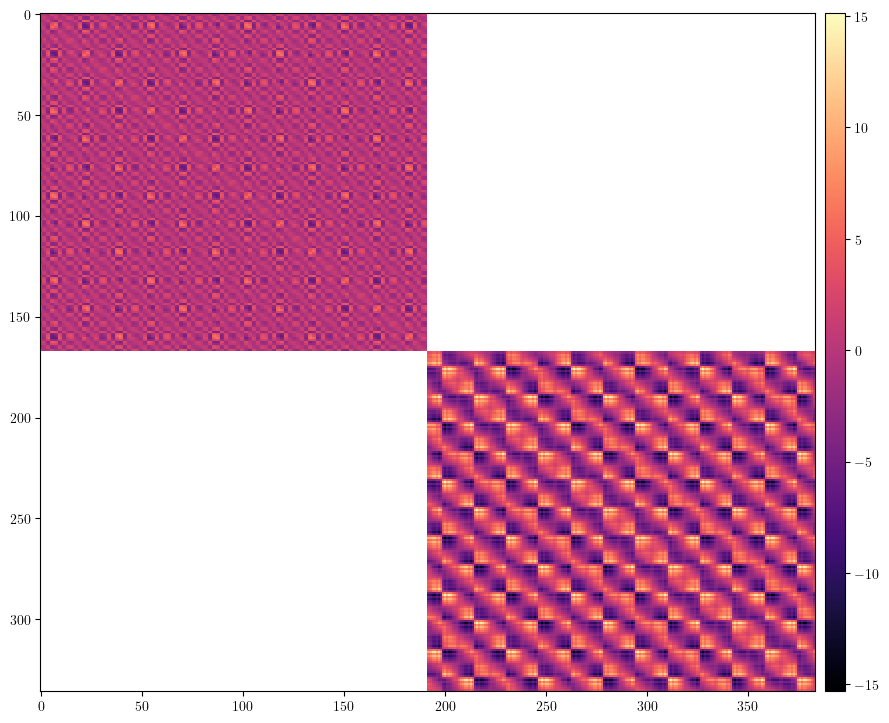

In [8]:
# Plot ORM (exclude skew blocks)

# RXX RXY
# RYX RYY

data = orm.clone()
data[data==0.0] = torch.nan

plt.figure(figsize=(10, 10))
img = plt.imshow(data.cpu().numpy(), cmap='magma', interpolation='nearest')
cax = plt.gcf().add_axes([plt.gca().get_position().x1 + 0.01, plt.gca().get_position().y0, 0.02, plt.gca().get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

In [9]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [10]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [11]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [12]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [13]:
# Compute coupling

c = coupling(ring, [])

In [14]:
# Several local knobs can be used to correct ID effects

# Normal quadrupole correctors
nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']

# Skew quadrupole correctors
nks = ['SD_S01_05', 'SD_S01_02', 'SD_S01_03', 'SD_S01_06']

In [15]:
# Define ORM observable

def observable_orm(kn, ks):
    orm = ORM(ring, orbit,  [kn, ks], ('kn', None, nkn, None), ('ks', None, nks, None), limit=1)
    return orm

kn = torch.tensor(6*[0.0], dtype=dtype)
ks = torch.tensor(4*[0.0], dtype=dtype)

print(observable_orm(kn, ks))
print(torch.func.jacfwd(observable_orm, 0)(kn, ks))
print(torch.func.jacfwd(observable_orm, 1)(kn, ks))

tensor([[ 1.2608,  0.3460, -0.2254,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7149,  0.3956,  0.0488,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4009,  0.9655,  1.1580,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  5.6044,  3.9261,  2.9078],
        [ 0.0000,  0.0000,  0.0000,  ...,  4.5002,  3.2682,  2.8291],
        [ 0.0000,  0.0000,  0.0000,  ...,  3.1543,  2.1224,  2.2974]],
       dtype=torch.float64)
tensor([[[-3.8566e-01, -2.2381e+00, -7.5455e-01, -1.1784e-01, -2.5358e-01,
          -2.2173e-02],
         [ 5.0295e-02,  1.2518e-01,  8.2528e-03, -1.6907e-01, -4.2751e-01,
          -5.0938e-02],
         [ 1.7644e-01,  9.0914e-01,  2.8314e-01, -7.3071e-02, -2.0108e-01,
          -2.6916e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.000

In [16]:
# Construct full target observable vector and corresponding responce matrix

def observable(knobs):
    kn, ks = torch.split(knobs, [6, 4])
    orm = observable_orm(kn, ks)
    return orm.flatten()

knobs = torch.tensor((6 + 4)*[0.0], dtype=dtype)
print((target := observable(knobs)).shape)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([129024])
torch.Size([129024, 10])


In [17]:
# To perform model free correction the response matrix should have full rank

print(torch.linalg.matrix_rank(matrix))

tensor(10)


In [18]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [19]:
# Insert ID into the existing lattice
# This will replace the target marker

error = ring.clone()
error.flatten()
error.insert(ID, 'MLL_S01', position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 192,
 'Matrix': 1,
 'Marker': 11}

In [20]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(error, [], matched=True, limit=1)

In [21]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(error, orbit, [], limit=1)

In [22]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(error, [], matched=True, advance=True, full=False).T

In [23]:
# Compute phase advances

mux_id, muy_id = advance(error, [], alignment=False, matched=True).T

In [24]:
# Compute coupling

c_id = coupling(error, [])

In [25]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0260, dtype=torch.float64)
tensor(-0.0114, dtype=torch.float64)


In [26]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


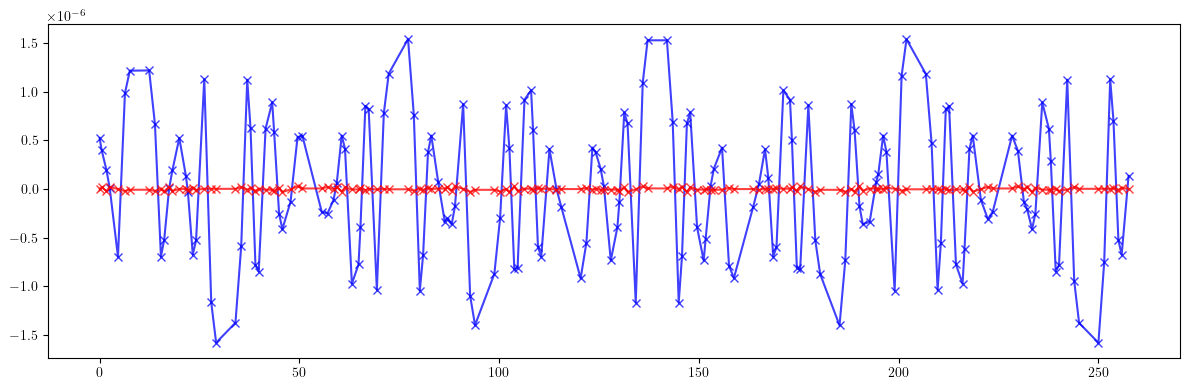

In [27]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

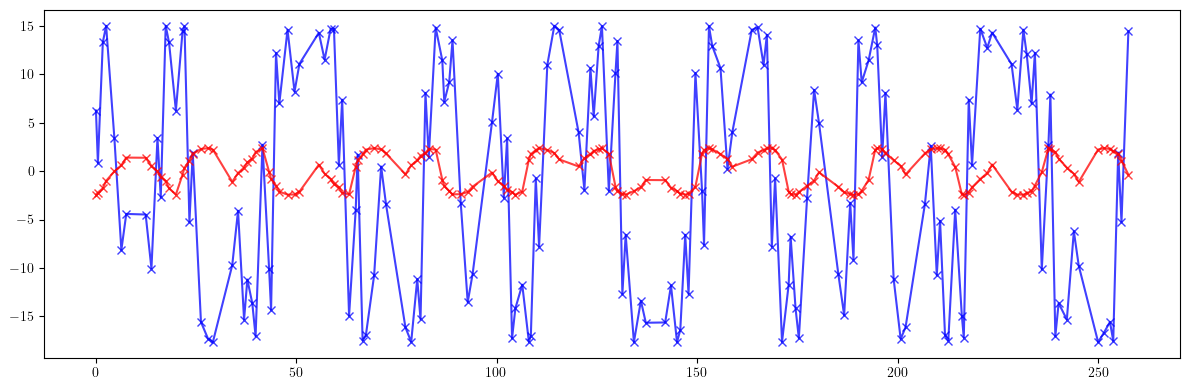

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)


In [28]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

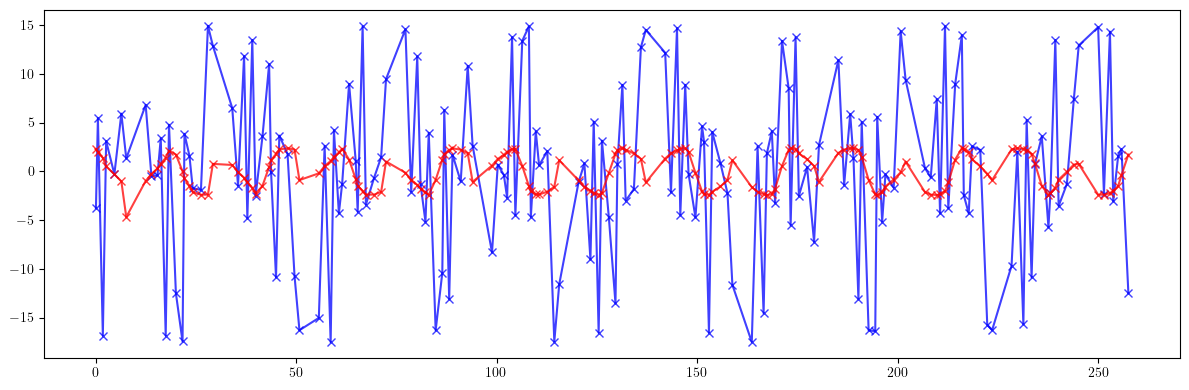

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)


In [29]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [30]:
# Define parametric observable vector (emulate tune measurement)

def observable_orm(kn, ks):
    orm = ORM(error, orbit,  [kn, ks], ('kn', None, nkn, None), ('ks', None, nks, None), limit=1)
    return orm

def observable(knobs):
    kn, ks = torch.split(knobs, [6, 4])
    orm = observable_orm(kn, ks)
    return orm.flatten()

In [31]:
# Check the residual vector norm

knobs = torch.tensor((6 + 4)*[0.0], dtype=dtype)

print(((observable(knobs) - target)**2).sum())

tensor(7992.7087, dtype=torch.float64)


In [32]:
# Optimization loop (model free)
# Note, covariance matrix is not used here since the vector is too long
# An alternative would be to use fewer correctors and/or BPMs

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor((6 + 4)*[0.0], dtype=dtype)

for _ in range(16):
    value = observable(knobs)
    knobs -= lr*torch.linalg.lstsq(matrix, value - target, driver='gels').solution
    print((value - target).norm())
print()

tensor(89.4020, dtype=torch.float64)
tensor(27.8191, dtype=torch.float64)
tensor(13.4461, dtype=torch.float64)
tensor(7.4096, dtype=torch.float64)
tensor(5.2216, dtype=torch.float64)
tensor(4.7424, dtype=torch.float64)
tensor(4.6709, dtype=torch.float64)
tensor(4.6623, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)
tensor(4.6615, dtype=torch.float64)



In [33]:
# Check the residual vector norm

print(((observable(knobs) - target)**2).sum())

tensor(21.7298, dtype=torch.float64)


In [34]:
# Apply final corrections

kn, ks = torch.split(knobs, [6, 4])

result = error.clone()

result.flatten()

for name, knob in zip(nkn, kn):
    result[name].kn = (result[name].kn + knob).item()
    
for name, knob in zip(nks, ks):
    result[name].ks = (result[name].ks + knob).item()
    
result.splice()

In [35]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(result, [], matched=True, limit=1)

In [36]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(result, orbit, [], limit=1)

In [37]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(result, [], matched=True, advance=True, full=False).T

In [38]:
# Compute phase advances

mux_result, muy_result = advance(result, [], alignment=False, matched=True).T

In [39]:
# Compute coupling

c_result = coupling(result, [])

In [40]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0006, dtype=torch.float64)
tensor(2.8963e-05, dtype=torch.float64)



In [41]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)


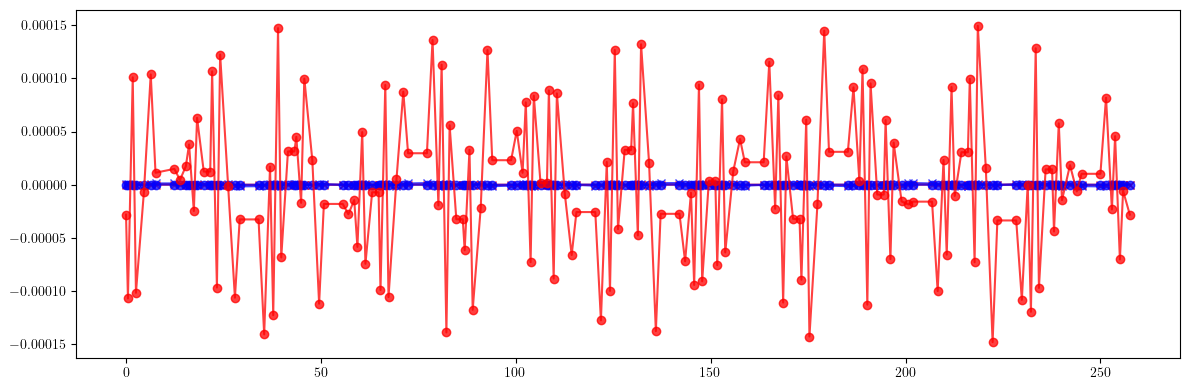

In [42]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

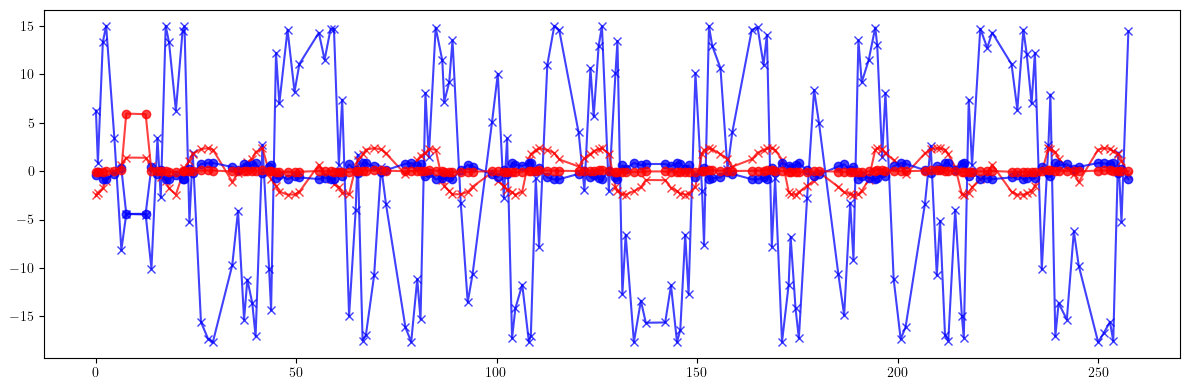

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(0.7689, dtype=torch.float64)
tensor(0.6475, dtype=torch.float64)



In [43]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

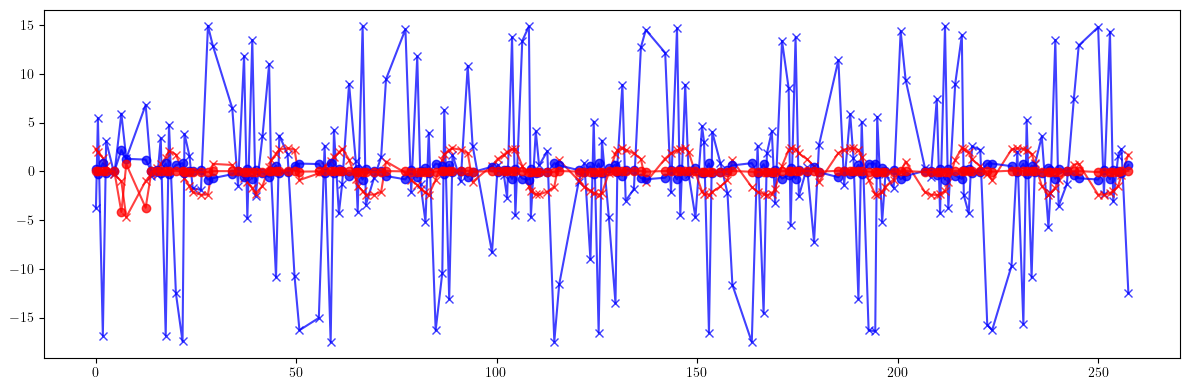

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)

tensor(0.5063, dtype=torch.float64)
tensor(0.4384, dtype=torch.float64)



In [44]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt())
print(100*(((muy - muy_result)/muy)**2).mean().sqrt())
print()